In [1]:
import json
from pathlib import Path
import pandas as pd 
import tensorflow as tf 
import numpy as np
from tensorflow.data import Dataset 
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import Model
import cv2
import matplotlib.pyplot as plt 

2024-12-21 07:03:00.223191: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734764580.350802     568 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734764580.390403     568 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-21 07:03:00.681580: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Setup and Dataset

In [2]:
with open("../config.json") as file:
    config = json.load(file)
 
aptos2019_path = Path(config["dataset"]["aptos_2019"]["balanced_resized"])
models_trained_path = Path(config["models_trained"])

In [3]:
csv = pd.read_csv(aptos2019_path / "labels.csv")
images_path = str(aptos2019_path / "images")

num_class = 5
def name2image_class2onehot(tensor):
    # Loading and processing image
    image_name = "/" + tensor["img_name"] + ".png"
    image_path = images_path + image_name
    image_file = tf.io.read_file(image_path)
    image_file = tf.io.decode_png(image_file,channels=3)
    image_file = tf.cast(image_file,tf.float32)
    image_file = tf.image.resize(image_file,[224,224])
    image_file /= 255.0
    # onehotting the class 
    onehot_class = tf.one_hot(tensor["class"], depth = num_class)
    
    return (image_file, onehot_class)

tf.random.set_seed(342)
aptos2019_dataset = (Dataset
                     .from_tensor_slices(dict(csv))
                     .shuffle(len(csv))
                     .map(name2image_class2onehot))

# Selecting sizes of train, val and test dataset
dataset_size = dict() 
dataset_size["train"] = 0.7 
dataset_size["val"]   = 0.2
dataset_size["test"]  = 0.1

# creating train, test, val datasets
for key in dataset_size:
    dataset_size[key] = int(dataset_size[key] * len(aptos2019_dataset))
dataset = dict()
dataset["train"] = aptos2019_dataset.take(dataset_size["train"]) 
dataset["val"] = aptos2019_dataset.skip(dataset_size["train"]).take(dataset_size["val"])
dataset["test"] = aptos2019_dataset.skip(dataset_size["train"] + dataset_size["val"]).take(dataset_size["test"]) 

# batching the splits
batch_size = 8
dataset["train"] = dataset["train"].batch(batch_size)
dataset["val"] = dataset["val"].batch(batch_size)
#  dataset["test"] = dataset["test"].batch(batch_size)

print("Splitting sizes:")
for key in dataset_size:
    print(f"- {key} size : {dataset_size[key]}")

# example of a tensor from train set
print("\nExample Tensor:")
for tensor in dataset["train"].take(1):
    print("Batched Input shape:", tensor[0].shape)
    print("Batched One-hot Tensor Shape:", tensor[1].shape)
    print("One-hot Tensor numpy", tensor[1].numpy()[0])

I0000 00:00:1734764593.602380     568 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Splitting sizes:
- train size : 12959
- val size : 3702
- test size : 1851

Example Tensor:
Batched Input shape: (8, 224, 224, 3)
Batched One-hot Tensor Shape: (8, 5)
One-hot Tensor numpy [0. 0. 0. 0. 1.]


2024-12-21 07:03:14.918066: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Grad-CAM on trained CNN-1 Experiment:

In [4]:
model_cnn_1 = load_model(models_trained_path / "cnn_1.keras")
model_cnn_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,455,297 (39.88 MB)

 Trainable params: 3,485,013 (13.29 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 6,970,028 (26.59 MB)

In [267]:
def grad_cam(input, actual_output):
    # Loading one image tensor
    x = tf.Variable(input)
 
    # Performing forward pass over complete model
    # This Setup for computing the gradients
    with tf.GradientTape() as tape:
        y = model_cnn_1(x)
        y_target = y[:, actual_output]

    # Printing if using the right output
    print(y)
    print(y_target) 
    
    # Gradients of last conv by backprop
    # "How much the output changes with change in conv variables"
    last_conv_layer = model_cnn_1.get_layer("conv2d_4") 
    gradients = tape.gradient(y_target, last_conv_layer.trainable_variables)    
    
    # Weights and biases Gradients
    gradients_w = gradients[0]
    gradients_b = gradients[1]
    
    # "How much each kernel is activated" 
    # Using only weight gradients
    activation_weights = np.sum(gradients_w, axis=(0,1,2)) / 128

    
    # Feature maps (Filters) output from the last conv layer for the current image 
    model_cnn_1_conv = Model(inputs = model_cnn_1.inputs, outputs = last_conv_layer.output)
    feature_maps = model_cnn_1_conv(x)[0]
    
    # Weighting each feature map and summing them 
    activation_map = np.dot(feature_maps, activation_weights) 
    
    # Resize to original image size
    activation_map_scaled = cv2.resize(activation_map, (224,224), interpolation=cv2.INTER_LINEAR)

    # activation_map_scaled[activation_map_scaled <0] = 0
    
    return activation_map, activation_map_scaled

In [6]:
test_data = dataset["test"].batch(1).take(20)

/home/karthikgpu/tf_gpu/tf218/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer']. Received: the structure of inputs=*
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.6077932e-09..1.0].


tf.Tensor(
[[1.39139065e-05 5.48002718e-04 5.35408792e-04 2.95796305e-01
  7.03106403e-01]], shape=(1, 5), dtype=float32)
tf.Tensor([0.2957963], shape=(1,), dtype=float32)
CLASS: 3


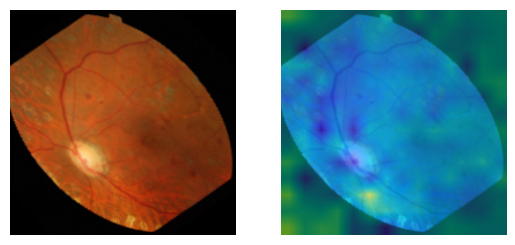

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2573388e-10..1.0].


tf.Tensor([[0.00383889 0.42302135 0.47462568 0.02136208 0.07715202]], shape=(1, 5), dtype=float32)
tf.Tensor([0.47462568], shape=(1,), dtype=float32)
CLASS: 2


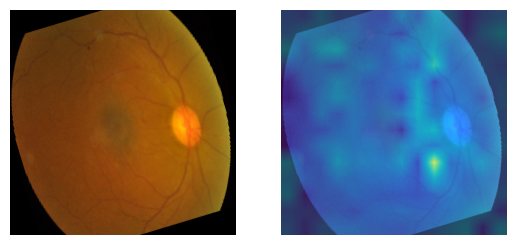

tf.Tensor([[1.2290337e-07 1.3346502e-03 9.6637636e-01 1.5220765e-02 1.7068109e-02]], shape=(1, 5), dtype=float32)
tf.Tensor([0.96637636], shape=(1,), dtype=float32)
CLASS: 2


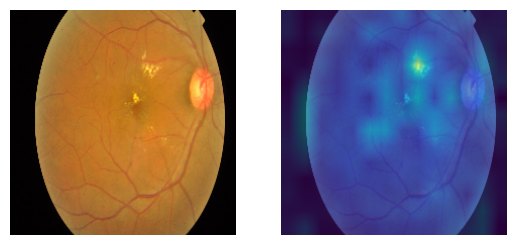

tf.Tensor([[1.0589356e-02 3.4847346e-03 8.5894233e-01 5.0374943e-05 1.2693325e-01]], shape=(1, 5), dtype=float32)
tf.Tensor([0.85894233], shape=(1,), dtype=float32)
CLASS: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9.000942e-10..1.0].


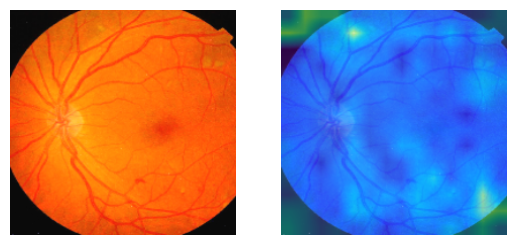

tf.Tensor([[4.3882127e-03 9.9510324e-01 4.1489468e-05 4.6313528e-04 3.9559391e-06]], shape=(1, 5), dtype=float32)
tf.Tensor([0.99510324], shape=(1,), dtype=float32)
CLASS: 1


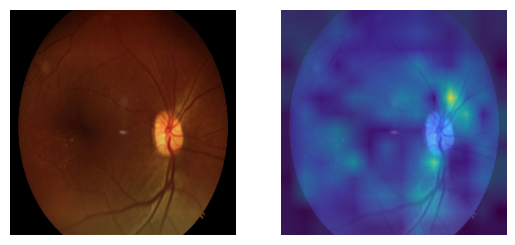

tf.Tensor([[9.9999917e-01 8.2027704e-08 6.7816359e-07 6.0565277e-12 8.3603409e-09]], shape=(1, 5), dtype=float32)
tf.Tensor([0.99999917], shape=(1,), dtype=float32)
CLASS: 0


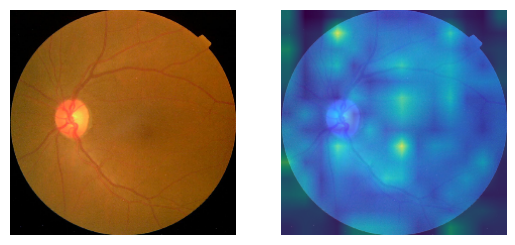

tf.Tensor([[2.1244510e-05 2.5990345e-02 9.7340143e-01 1.7261381e-04 4.1437332e-04]], shape=(1, 5), dtype=float32)
tf.Tensor([0.9734014], shape=(1,), dtype=float32)
CLASS: 2


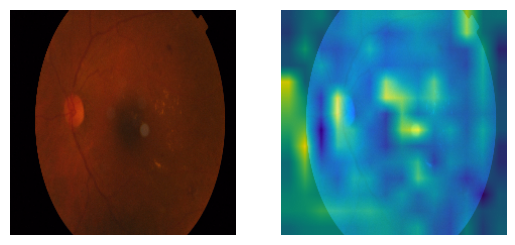

tf.Tensor(
[[9.99191344e-01 4.56926588e-04 2.33421772e-04 1.21201481e-06
  1.17146854e-04]], shape=(1, 5), dtype=float32)
tf.Tensor([0.99919134], shape=(1,), dtype=float32)
CLASS: 0


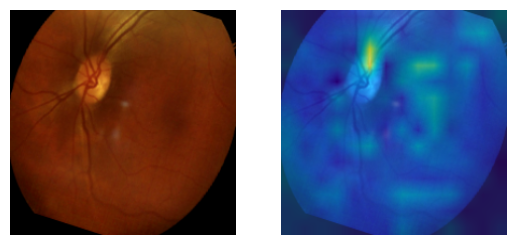

tf.Tensor([[9.9993396e-01 2.7948599e-06 6.3253865e-05 3.1372322e-13 2.0190847e-09]], shape=(1, 5), dtype=float32)
tf.Tensor([0.99993396], shape=(1,), dtype=float32)
CLASS: 0


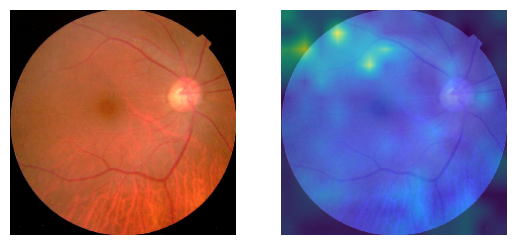

tf.Tensor([[2.0240246e-05 6.1756885e-03 9.9099231e-01 1.3160198e-03 1.4957523e-03]], shape=(1, 5), dtype=float32)
tf.Tensor([0.9909923], shape=(1,), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.026255e-10..0.99999994].


CLASS: 2


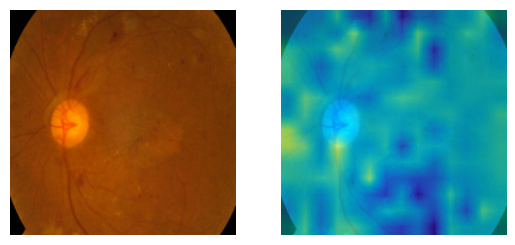

tf.Tensor([[1.6639351e-04 3.7985505e-03 2.7748384e-02 7.6542296e-03 9.6063250e-01]], shape=(1, 5), dtype=float32)
tf.Tensor([0.9606325], shape=(1,), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.443706e-10..1.0].


CLASS: 4


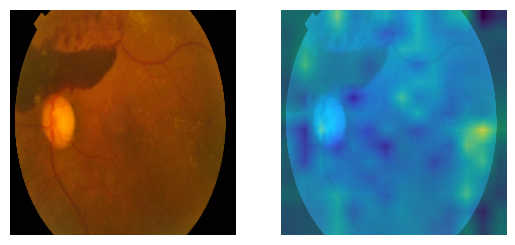

tf.Tensor([[2.6531926e-13 2.3871031e-05 9.9995542e-01 4.3775765e-07 2.0316098e-05]], shape=(1, 5), dtype=float32)
tf.Tensor([0.9999554], shape=(1,), dtype=float32)
CLASS: 2


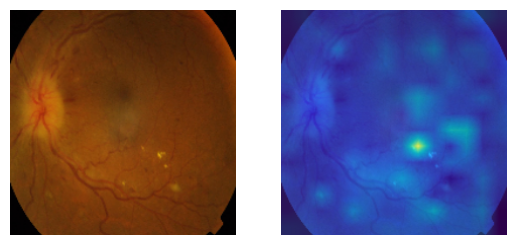

tf.Tensor([[2.4061377e-05 1.2586358e-02 1.1343108e-01 2.8304622e-02 8.4565383e-01]], shape=(1, 5), dtype=float32)
tf.Tensor([0.84565383], shape=(1,), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0418546e-09..1.0].


CLASS: 4


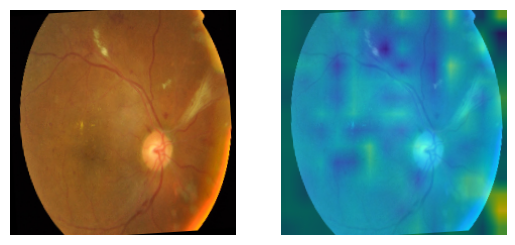

tf.Tensor([[1.9109846e-06 3.4988776e-04 5.9271124e-03 9.5365858e-01 4.0062524e-02]], shape=(1, 5), dtype=float32)
tf.Tensor([0.9536586], shape=(1,), dtype=float32)
CLASS: 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2700525e-09..1.0].


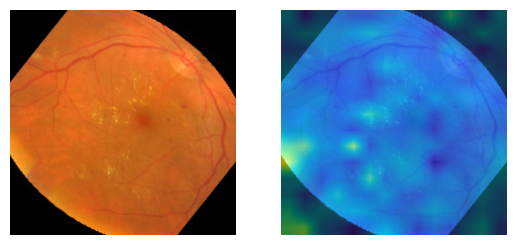

tf.Tensor([[1.2912374e-05 6.2886364e-04 4.2588669e-01 5.6964463e-01 3.8269265e-03]], shape=(1, 5), dtype=float32)
tf.Tensor([0.4258867], shape=(1,), dtype=float32)
CLASS: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.6297703e-09..0.99999994].


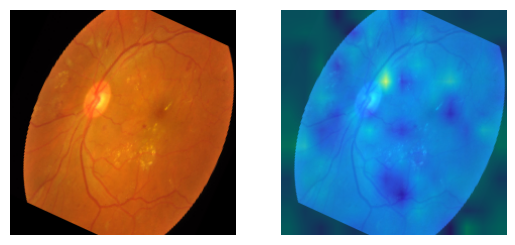

tf.Tensor([[7.7967424e-12 1.9400188e-08 1.4458552e-04 9.9979514e-01 6.0289633e-05]], shape=(1, 5), dtype=float32)
tf.Tensor([0.99979514], shape=(1,), dtype=float32)
CLASS: 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.6297703e-09..0.99999994].


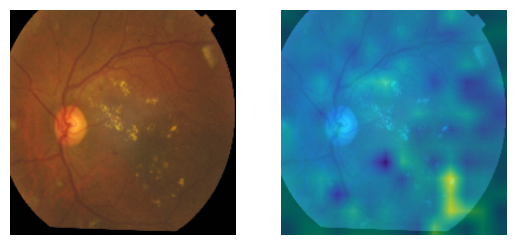

tf.Tensor([[2.6637045e-14 1.7968378e-09 1.9797814e-09 1.0000000e+00 2.8758423e-10]], shape=(1, 5), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
CLASS: 3


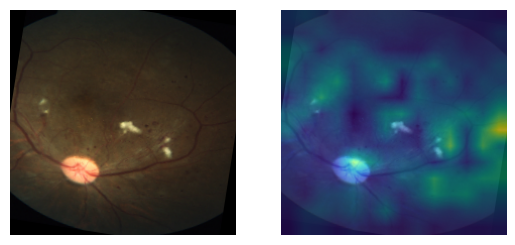

tf.Tensor([[2.0449787e-07 5.0452701e-04 6.4483914e-03 9.8342079e-01 9.6260933e-03]], shape=(1, 5), dtype=float32)
tf.Tensor([0.9834208], shape=(1,), dtype=float32)
CLASS: 3


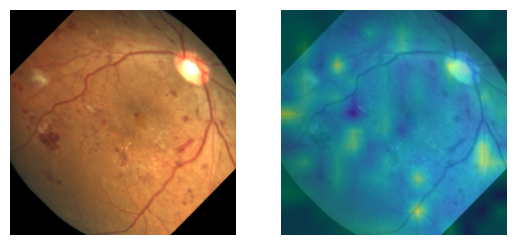

tf.Tensor([[9.9821389e-01 2.9967370e-04 1.4865614e-03 4.7713110e-12 7.7944060e-09]], shape=(1, 5), dtype=float32)
tf.Tensor([0.9982139], shape=(1,), dtype=float32)
CLASS: 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.6297703e-09..0.99999994].


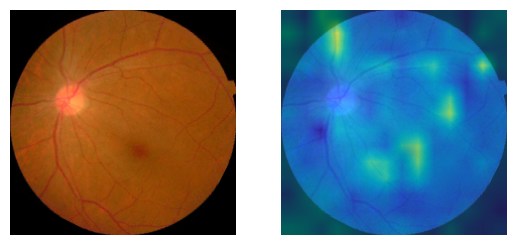

tf.Tensor([[1.0000000e+00 2.0966499e-12 5.8362890e-23 2.8412558e-16 3.7829429e-21]], shape=(1, 5), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
CLASS: 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1579857e-09..0.99999994].


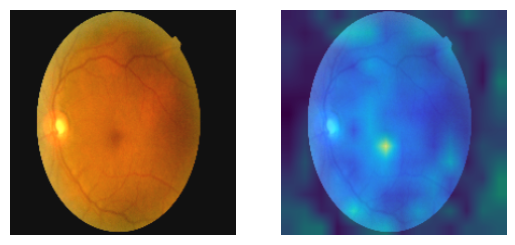

In [268]:
for x in test_data:
    image = x[0]
    label = np.argmax(x[1])
    activation_map, activation_map_scaled = grad_cam(image,label)

    print("CLASS:", label)

    # Original image
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(image[0])

    # Overlay activation map over image
    plt.subplot(1,2,2)
    alpha = 1
    beta = 0.005
    image_to_plot = activation_map_scaled
    original_image = image[0].numpy()
    original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)
    image_to_plot = cv2.normalize(image_to_plot, None, 0, 255, cv2.NORM_MINMAX) 
    image_to_plot = cv2.applyColorMap(image_to_plot.astype(np.uint8),cv2.COLORMAP_VIRIDIS)
    image_to_plot = cv2.addWeighted(image[0].numpy(), alpha, image_to_plot.astype(np.float32), beta, 0)
    image_to_plot = cv2.normalize(image_to_plot,None, 0, 1, cv2.NORM_MINMAX)
    image_to_plot = cv2.cvtColor(image_to_plot,cv2.COLOR_BGR2RGB)
    
    plt.axis('off')
    plt.imshow(image_to_plot)

    plt.show()